参考文献：
https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # 連結された訓練データとテストデータを返す
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # 分割された訓練データとテストデータを返す
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training Y Shape = {}'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test Y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training Y Shape = 891
Test X Shape = (418, 11)
Test Y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## １．探索的データ分析

### 1.1 概要

In [3]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
80,81,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.00,NaN,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.00,B96 B98,S


In [4]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
25,917,3,"Robins, Mr. Alexander A",male,50.0,1,0,A/5. 3337,14.50,NaN,S
279,1171,2,"Oxenham, Mr. Percy Thomas",male,22.0,0,0,W./C. 14260,10.50,NaN,S
96,988,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.85,C46,S


## 1.2 欠損値

In [5]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)
    print('\n')

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### 1.2.1 Age
Ageの欠損値を単に中央値で埋めるのは良い選択ではない。AgeはPclassと大きな相関をもっているためPclassグループで中央値をとるのが合理的な選択。

In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# SexとPclassグループの中央値でAgeの欠損を埋める
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
    

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


### 1.2.3 Embarked
2人の女性がEmbarked欠損してるんだけど、二人ともチケットナンバーが同じだから、互いを知ってる可能性があるね。Nameをググったらひとりはメイドっぽい。ついでにどこから乗ったかも書いてあったわ。Sだって。んじゃSで埋めるか。

In [8]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# Embarkedの欠損をSで埋める
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 1.2.3 Fare
Fareは一つだけ欠損があるね。Fareはfamilysizeとpclassに相関あるってのはなんとなくわかると思う。男性かつ3classで一緒に乗った家族がいない人でグルーピングして、その中央値で埋めるか。

In [10]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp', 'Sex']).Fare.median()[3][0][0]['male']
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

### 1.2.4 Cabin
・ボートデッキには６つの部屋（T,U,W,X,Y,Z）があるが、データセットにはTしか存在していない<br>
・A,B,Cデッキは1stクラスの乗客がいた<br>
・D,Eにはすべてのクラスの乗客がいた<br>
・F,Gには2nd,3rdの乗客がいた<br>
・AデッキからGデッキに行くには、階段までの距離が遠いため生存率に影響を及ぼしているかもしれない<br>

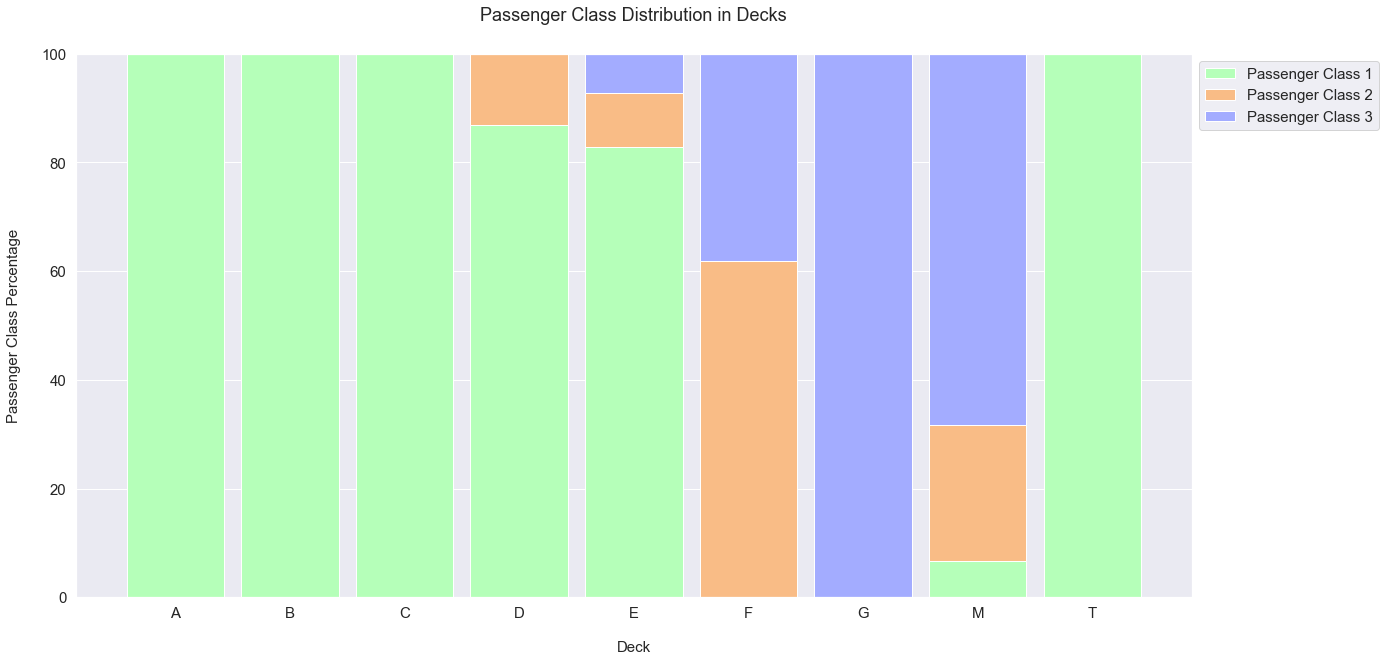

In [12]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

・Tデッキは一人しかおらず、TデッキはAデッキに近いためAに置き換える<br>
・MデッキはCabinが欠損してる人たち

In [13]:
# T deckの乗客をA  deckに置き換える
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

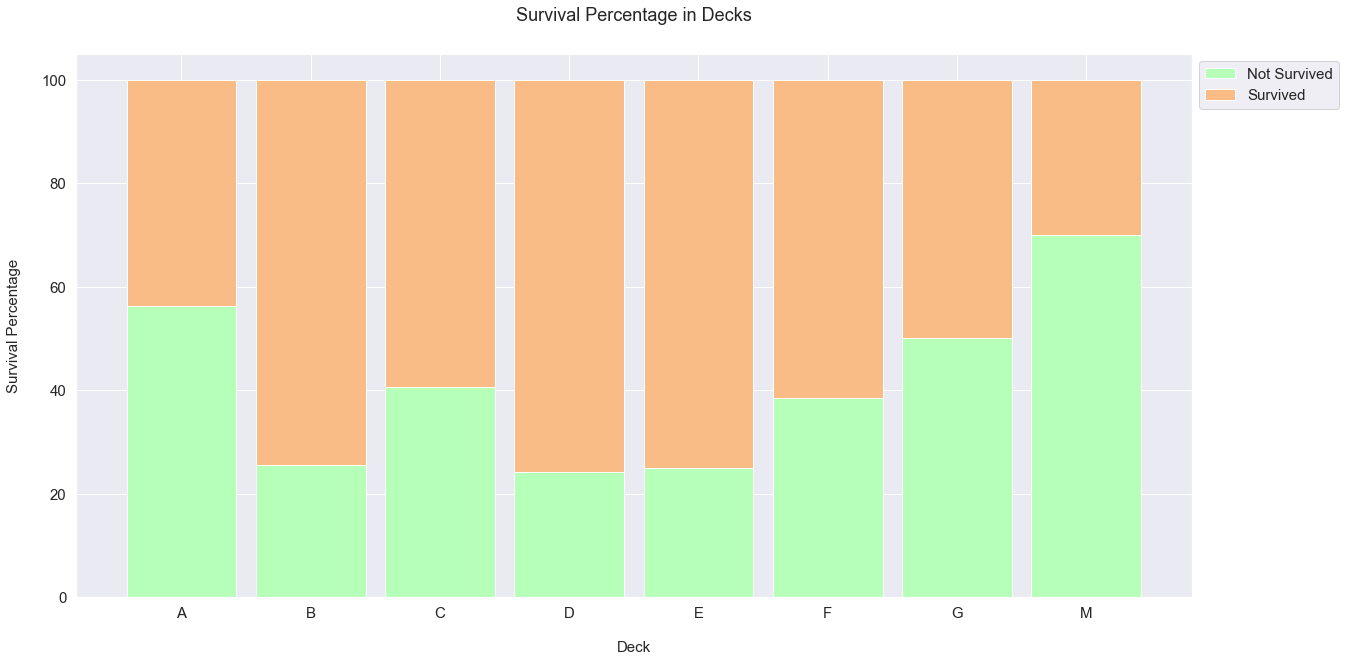

In [14]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

・ABCデッキの人たちは'ABC'とラベル付けする。何故なら彼らは全員1stクラスの乗客だからだ<br>
・DEの人たちは'DE'にまとめる。なぜなら彼らは同様のクラス同士かつ生存率がにかよっているからである<br>
・上記と同様の理由でFGはFGでまとめる<br>
・Mデッキはグループ化しない。これらは他のグループとは性質がことなるし、生存率も低く出ているから。

In [15]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [16]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0
Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


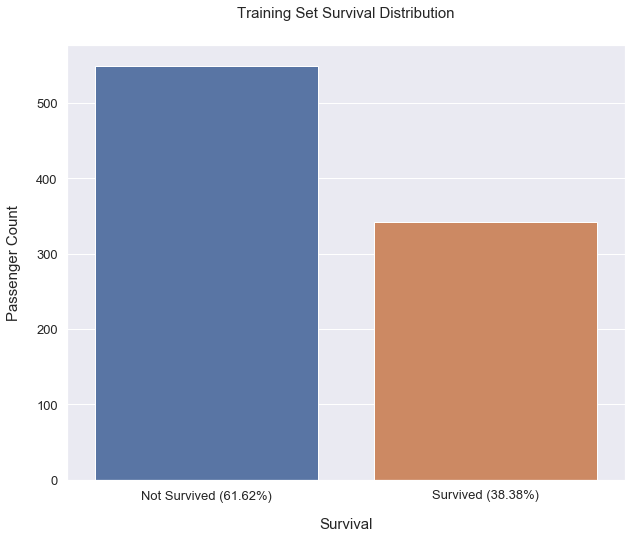

In [17]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

## 1.4 Correlations
相関係数0.1以上の特徴量ペアをみてみよう。

In [18]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True) # 奇数行は同じ特徴量同士の相関になるから削除
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index) # 相関係数が1.0（同じ特徴量同士））のものを削除

In [19]:
df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [20]:
# 高い相関の訓練データ
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [21]:
# 高い相関のテストデータ
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577488
8,Age,Pclass,0.526789
10,Age,Fare,0.345351
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172031


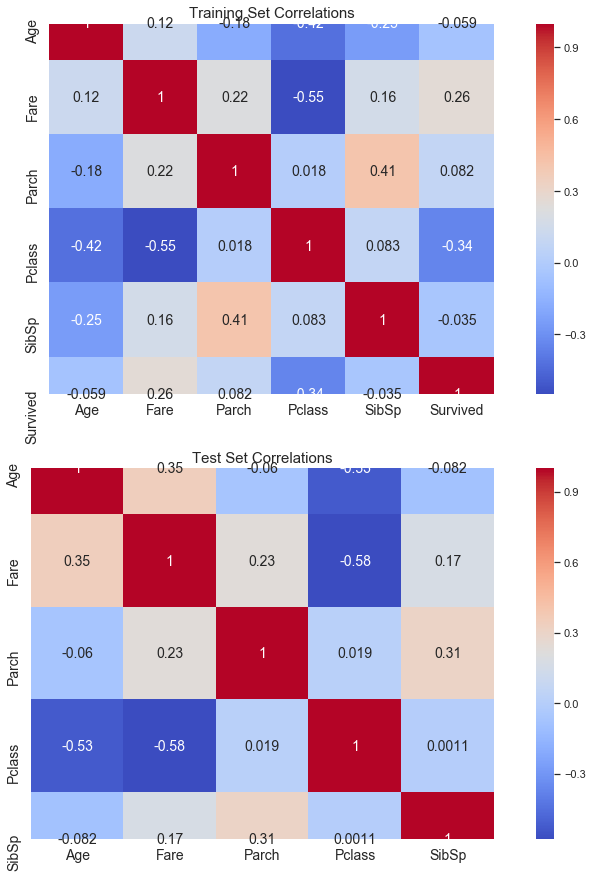

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## 1.5 Target Distribution in Features
### 1.5.1 Continuous Features

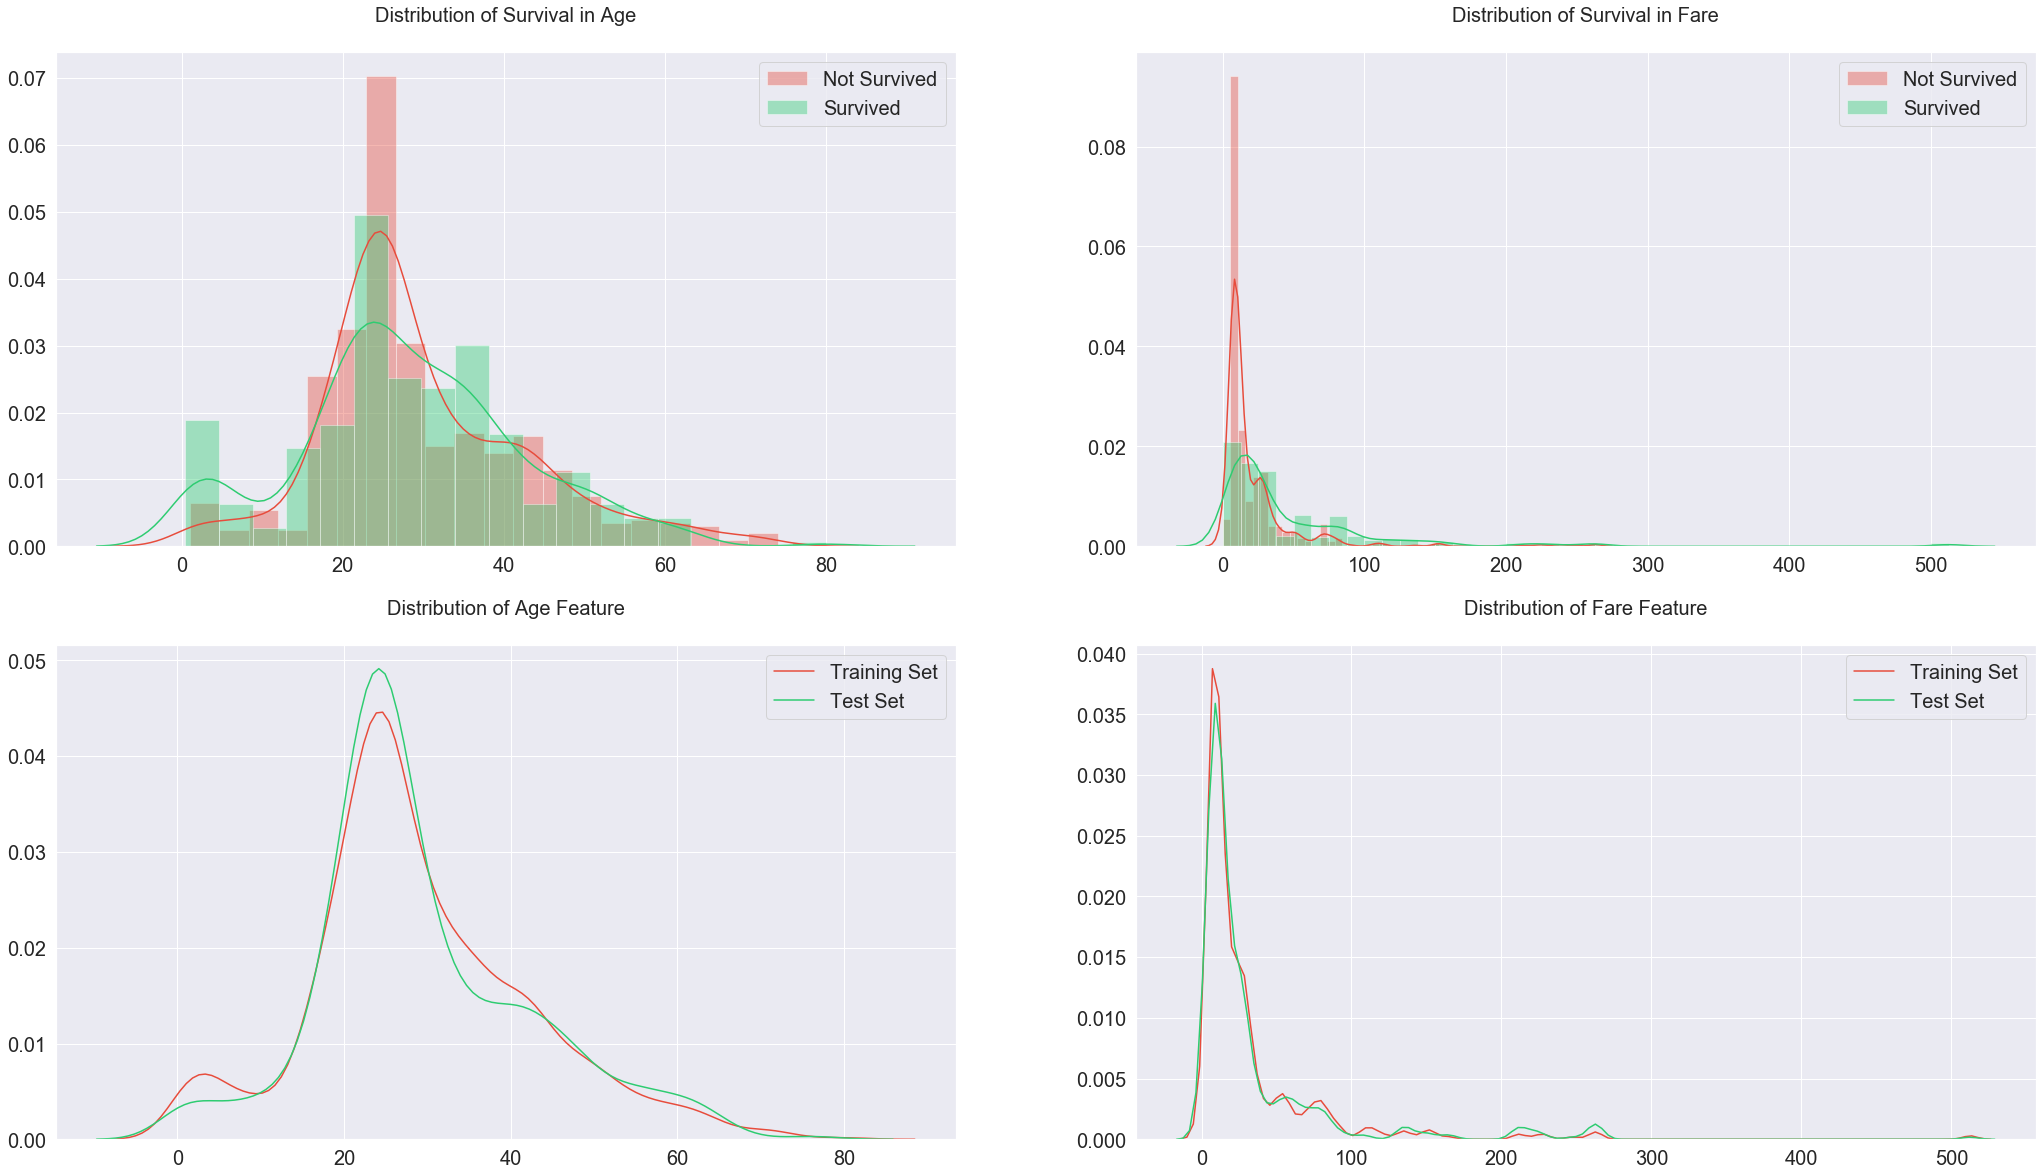

In [23]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

### 1.5.2 Categorical Features

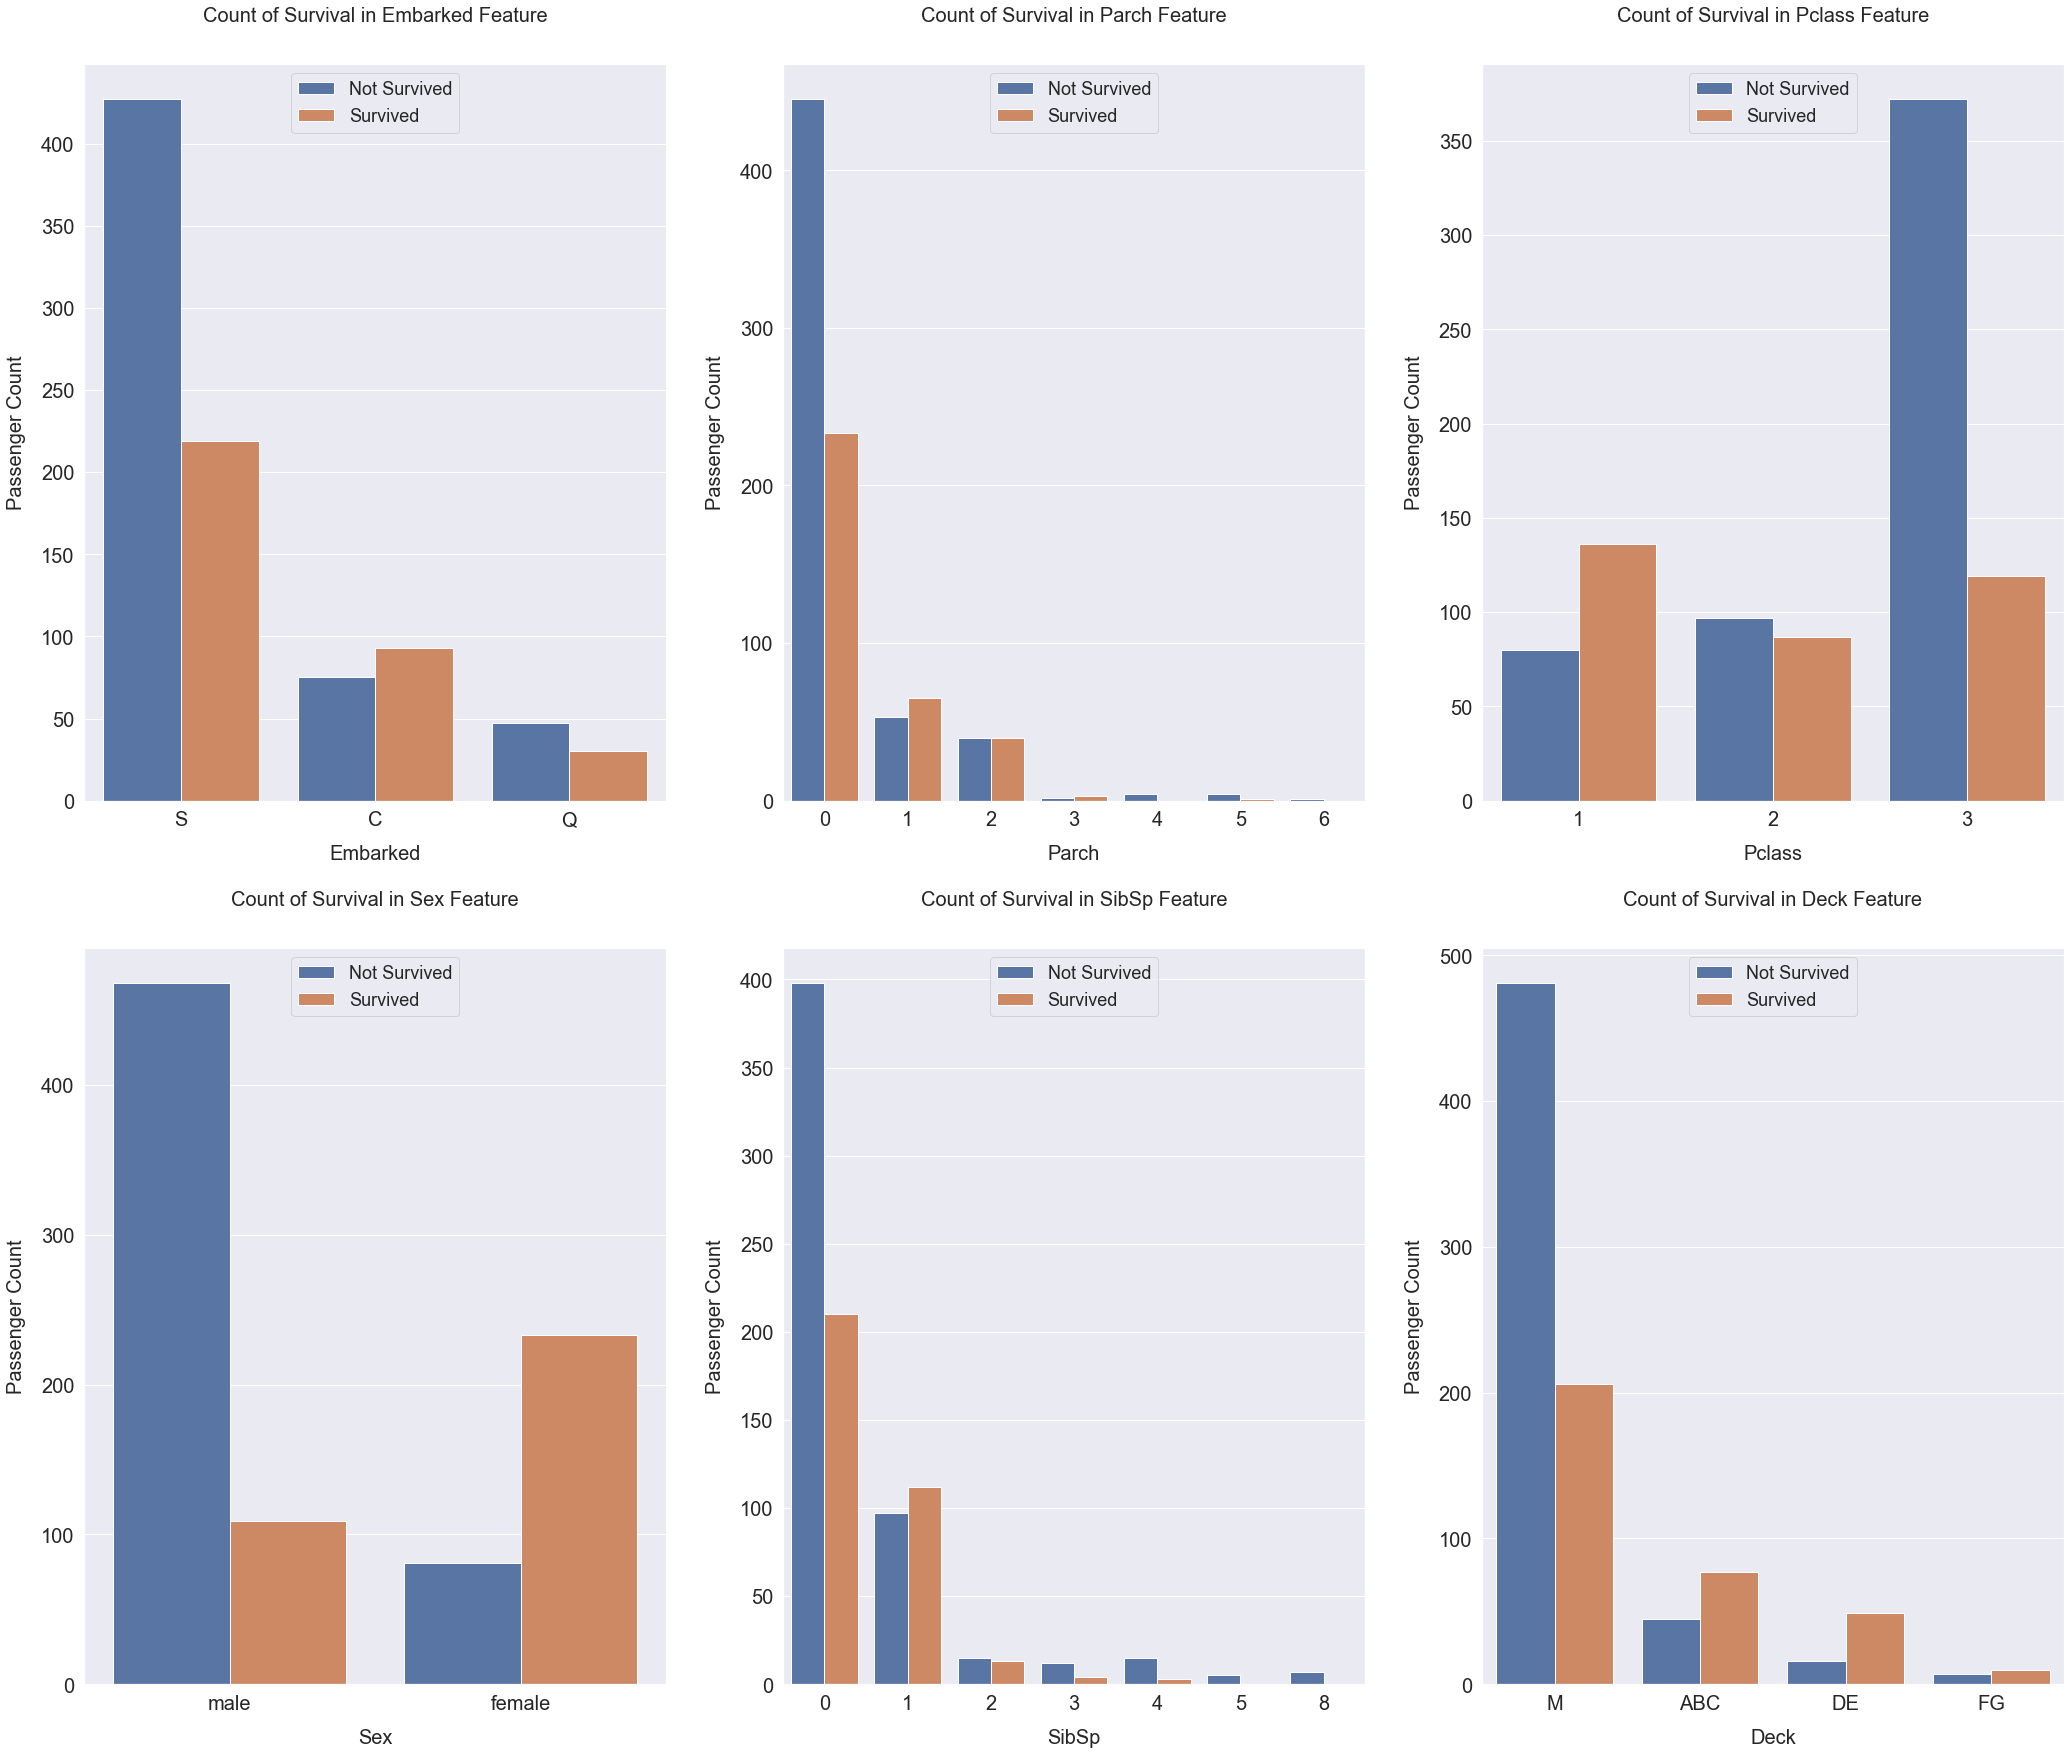

In [24]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

In [25]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# 2. Feature Engineering
## 2.1 Binning Coutinuous Features
### 2.1.1 Fare
binning：年齢→年代のように適当な区切りで分割すること<br>
ビン分割してみると単に分布を見てみたときと比較して、年代ごとに生存率の偏りがあることが分かる。たとえば(15.742, 23.25]の生存率が高いことは分布を見るだけではわからない。

In [26]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

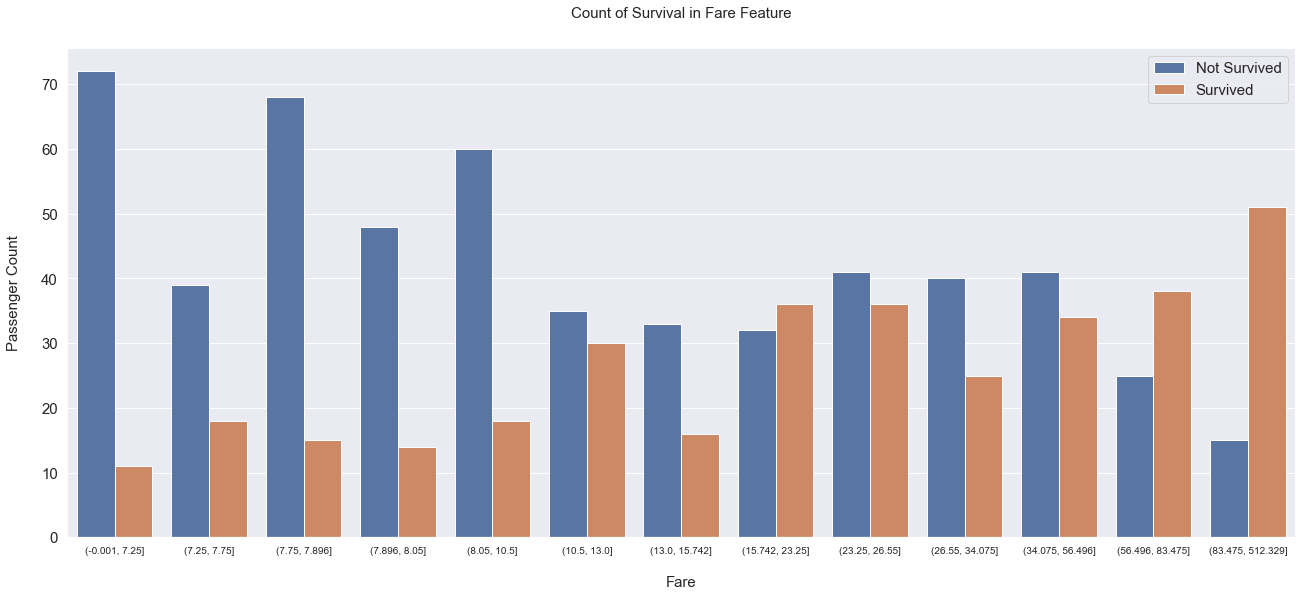

In [27]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### 2.1.2 Age
Ageも上記と同様にデータに偏りがあるね。

In [28]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

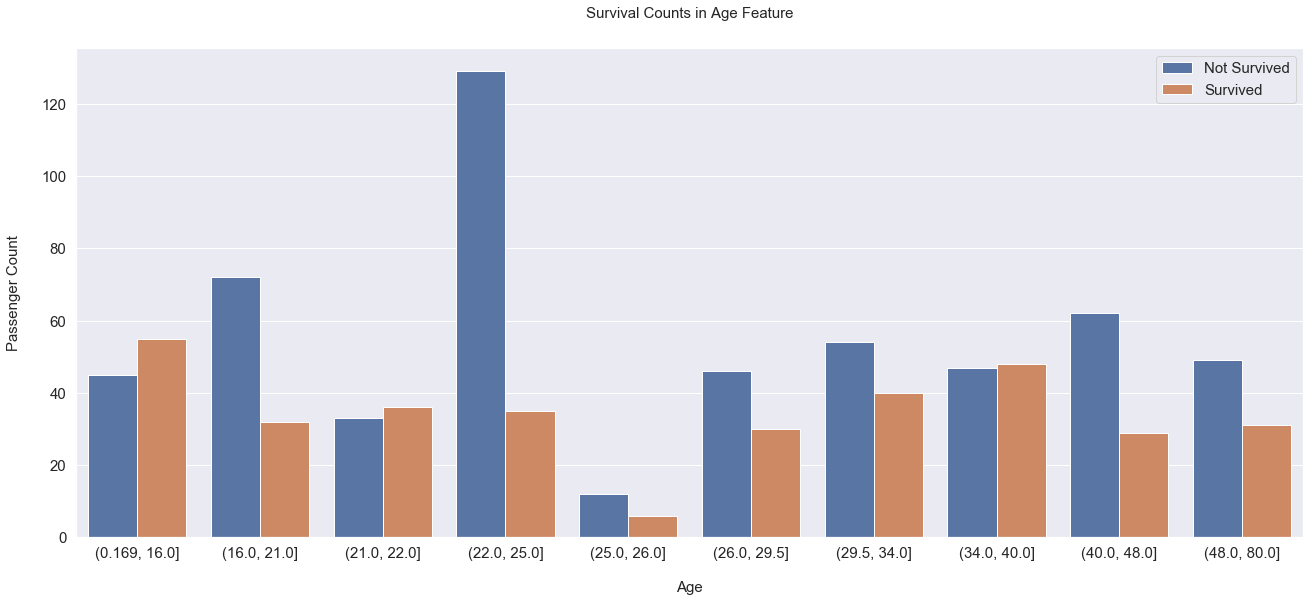

In [29]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## 2.2 Frequency Encoding
Family_size は　SibSp + Parch + 1で求めることができる。
・Family_sizeが1の人をAloneにラベリングする
・Family_sizeが2,3,4の人をSmallにラベリングする
・Family_sizeが5,6の人をMediumにラベリングする
・Family_sizeが7,8の人をLargeにラベリングする

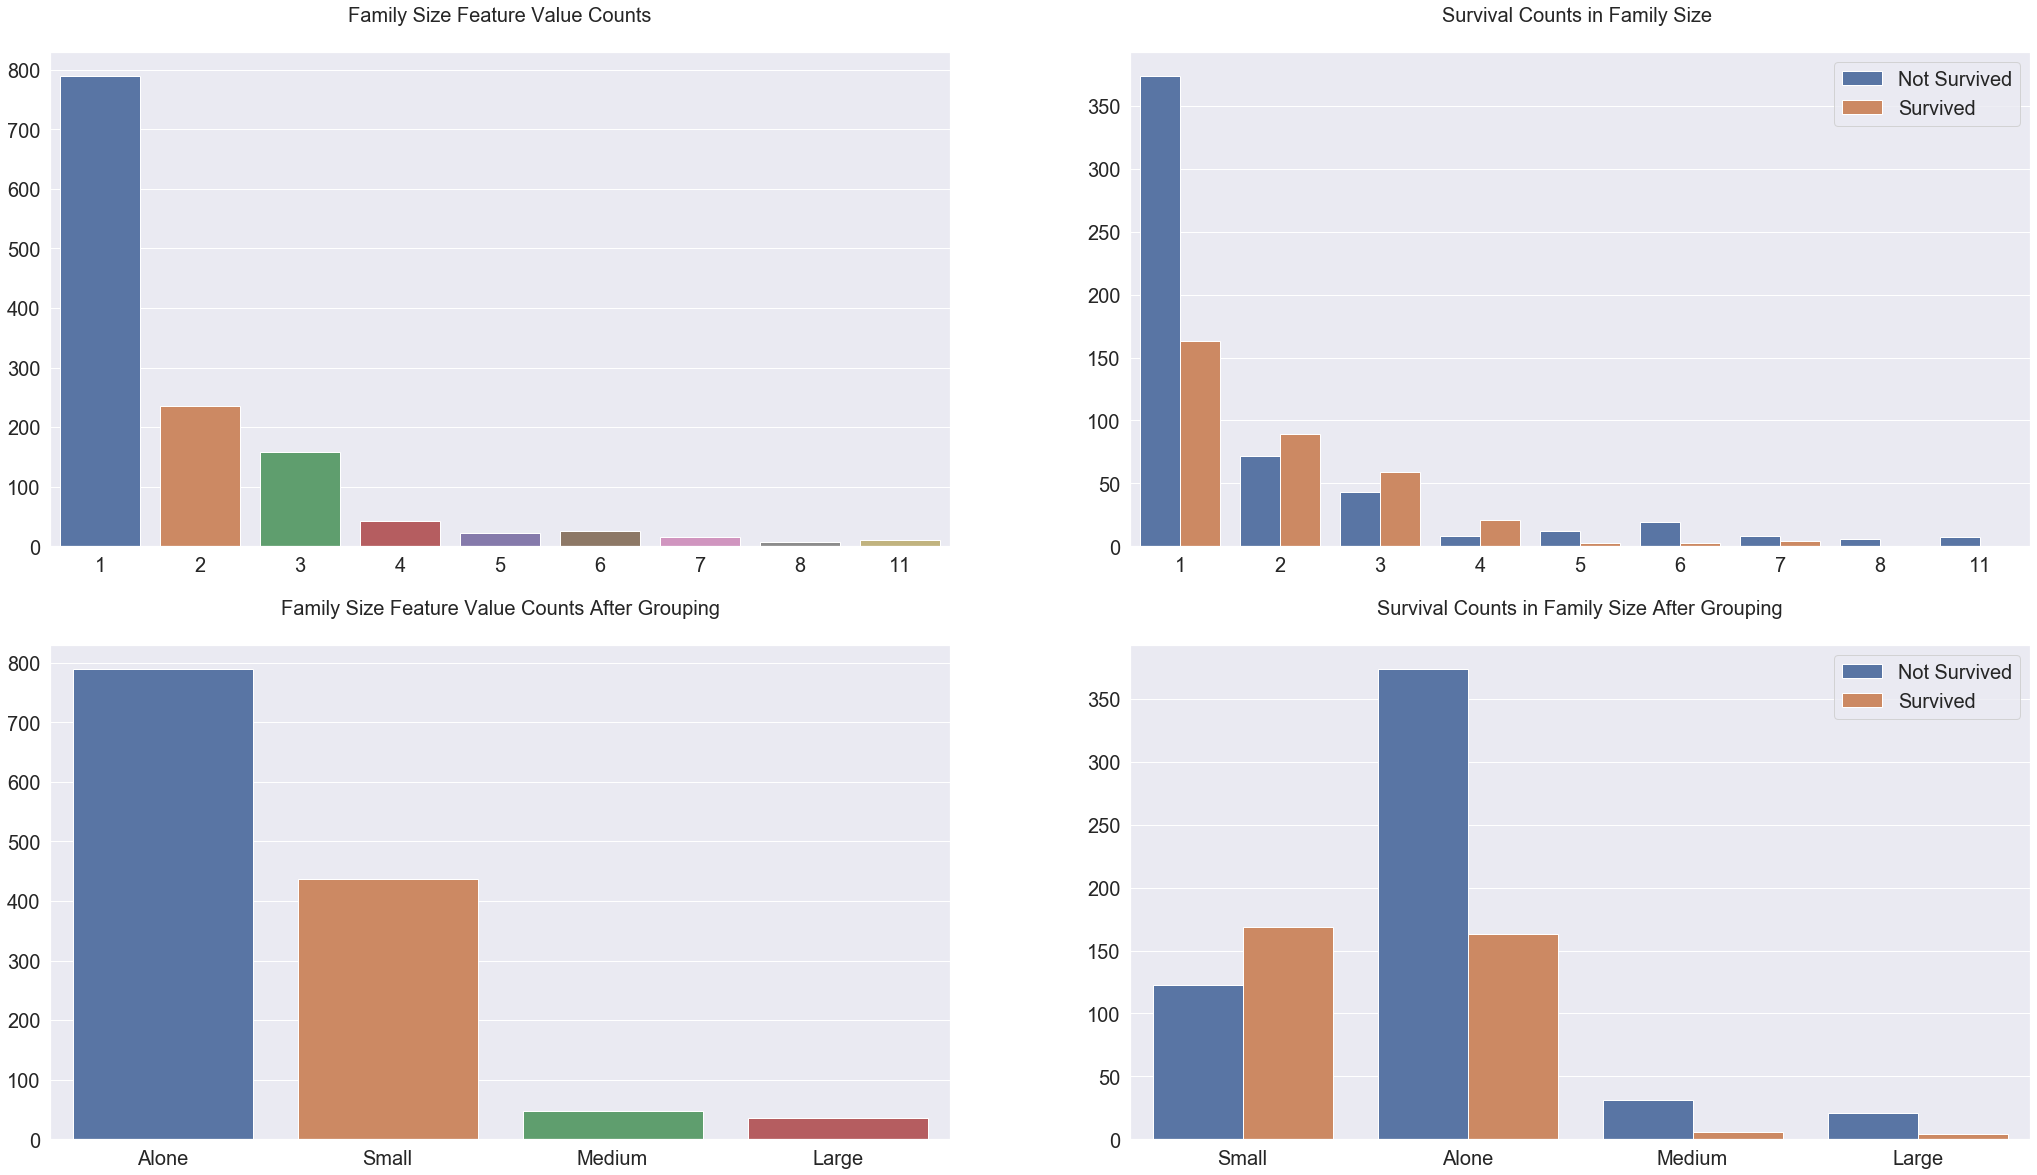

In [30]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

Ticketは様々な固有の値を持つものが多いため、出現する頻度でグループ化すると分析しやすくなるよ

### TicketはFamilysizeとどう違うだろうか？
多くの乗客はグループでタイタニック号に乗り込んでいる。内訳は、友人、メイド、ナニーだったりする。彼らはfamilyとしてはカウントされないが、同じチケットを使っているだろう

### Ticketの接頭辞でTicketをグルーピングしないのは何故？
もしチケットの接頭辞が何らかの意味を持っているなら、PclassやEmbarkedに既にその特徴量の性質が組み込まれているから

groupbyのわかりやすい解説<br>
https://qiita.com/propella/items/a9a32b878c77222630ae

In [31]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

↑は同じチケット名を持つ頻度を新たな特徴量として追加している

In [32]:
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency
0,"(21.0, 22.0]",M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2
2,"(25.0, 26.0]",M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2
4,"(34.0, 40.0]",M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1


In [33]:
df_all[df_all['Ticket']=='PC 17599']

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2
1125,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mr. John Bradley",0,1126,1,male,1,NaN,PC 17599,2,Small,2


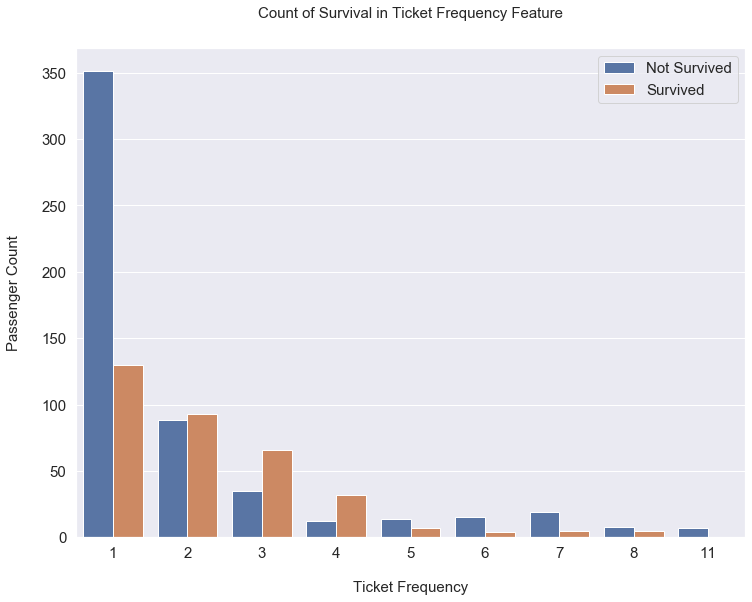

In [34]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

Ticket Frequency:同じチケットを持っている人たち→同じグループで乗船した人たち<br>
グラフを参照すると、２，３，４のメンバーは高い生存率を記録している。4グループ以上で乗船した人たちは生存率が低いね。これはFamilySizeに非常によく似た特徴だ。しかし僅かな違いがある。

## Title & is Married
Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona→Miss/Mrs/Ms<br>
Dr, Col, Major, Jonkheer, Capt, Sir, Don and Rev→Dr/Military/Noble/Clergy<br>
Masterは２６歳で男の中では高い生存率を持っている<br>
<br>
Is_Marriedは接頭辞Mrsから新たな特徴量として追加できる

In [35]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

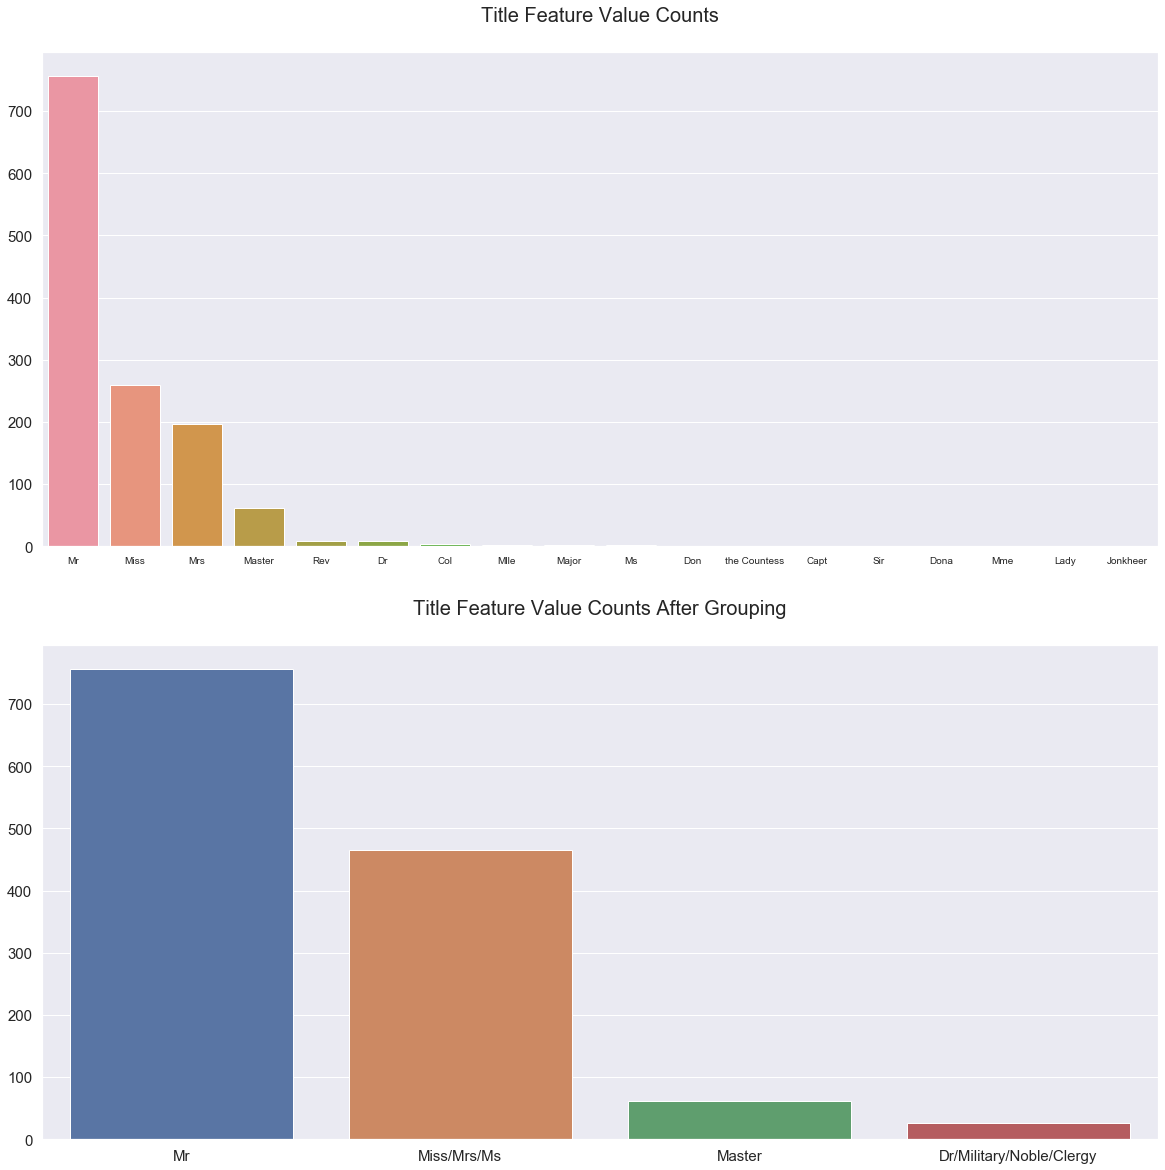

In [36]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## 2.4 Target Encoding
extract_surnameは特徴量nameから敬称を抽出するために用いられる。特徴量Familyは抽出された敬称から作られる。これは同じ家族同士をグルーピングするために必要。

In [37]:
def extract_surname(data):
    
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
        
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [38]:
df_all['Name'].iloc[5]

'Moran, Mr. James'

In [39]:
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Family
0,"(21.0, 22.0]",M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0,Braund
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Miss/Mrs/Ms,1,Cumings
2,"(25.0, 26.0]",M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Miss/Mrs/Ms,0,Heikkinen
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Miss/Mrs/Ms,1,Futrelle
4,"(34.0, 40.0]",M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0,Allen


In [40]:
df_test['Family'].unique()

array(['Kelly', 'Wilkes', 'Myles', 'Wirz', 'Hirvonen', 'Svensson',
       'Connolly', 'Caldwell', 'Abrahim', 'Davies', 'Ilieff', 'Jones',
       'Snyder', 'Howard', 'Chaffee', 'del Carlo', 'Keane', 'Assaf',
       'Ilmakangas', 'Assaf Khalil', 'Rothschild', 'Olsen', 'Flegenheim',
       'Williams', 'Ryerson', 'Robins', 'Ostby', 'Daher', 'Brady',
       'Samaan', 'Louch', 'Jefferys', 'Dean', 'Johnston', 'Mock',
       'Katavelas', 'Roth', 'Cacic', 'Sap', 'Hee', 'Karun', 'Franklin',
       'Goldsmith', 'Corbett', 'Kimball', 'Peltomaki', 'Chevre',
       'Shaughnessy', 'Bucknell', 'Coutts', 'Smith', 'Pulbaum', 'Hocking',
       'Fortune', 'Mangiavacchi', 'Rice', 'Cor', 'Abelseth', 'Davison',
       'Chaudanson', 'Dika', 'McCrae', 'Bjorklund', 'Bradley', 'Corey',
       'Burns', 'Moore', 'Tucker', 'Mulvihill', 'Minkoff', 'Nieminen',
       'Ovies y Rodriguez', 'Geiger', 'Keeping', 'Miles', 'Cornell',
       'Aldworth', 'Doyle', 'Boulos', 'Straus', 'Case', 'Demetri', 'Lamb',
       'Khalil'

In [41]:
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]

In [42]:
# トレーニングセットとテストセットの両方に出現しているfamiliesのリストを生成
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family', 'Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket', 'Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0] 

In [43]:
non_unique_families # トレーニングセットとテストセットの両方に出現しているFamilyの要素を抽出（？）

['Cumings',
 'McCarthy',
 'Palsson',
 'Sandstrom',
 'Bonnell',
 'Andersson',
 'Rice',
 'Williams',
 'Vander Planke',
 'McGowan',
 'Asplund',
 'Fortune',
 'Spencer',
 'Laroche',
 'Rogers',
 'Lennon',
 'Samaan',
 'Faunthorpe',
 'Ostby',
 'West',
 'Goodwin',
 'Moubarek',
 'Kink',
 'Chronopoulos',
 'Caldwell',
 'Carrau',
 'Ford',
 'Chaffee',
 'Dean',
 'Greenfield',
 'White',
 'Johansson',
 'Moore',
 'Peter',
 'Robins',
 'Weisz',
 'Boulos',
 'Andrew',
 'van Billiard',
 'Olsen',
 'Sage',
 'Cribb',
 'Watt',
 'Goldsmith',
 'Smith',
 'Klasen',
 'Lefebre',
 'Becker',
 'KinkHeilmann',
 'Brown',
 'Carr',
 'Kiernan',
 'Hold',
 'Murphy',
 'Minahan',
 'Rosblom',
 'Touma',
 'Abbott',
 'Olsson',
 'Connolly',
 'Allison',
 'Kelly',
 'McCoy',
 'Keane',
 'Fleming',
 'Hays',
 'Ryerson',
 'Lahtinen',
 'Nilsson',
 'Wick',
 'Spedden',
 'Dennis',
 'Frauenthal',
 'Burns',
 'Fox',
 'Davison',
 'Coutts',
 'Elias',
 'del Carlo',
 'Warren',
 'Harder',
 'Wiklund',
 'Widener',
 'Betros',
 'Nakid',
 'Davies',
 'Oreskov

In [44]:
df_family_survival_rate

,Survived,Family_Size
Family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
de Mulder,1.0,1.0
de Pelsmaeker,0.0,1.0
del Carlo,0.0,2.0


In [45]:
df_train.groupby('Family')['Survived', 'Family_Size'].median()

,Survived,Family_Size
Family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
de Mulder,1.0,1.0
de Pelsmaeker,0.0,1.0
del Carlo,0.0,2.0


In [46]:
family_rates # family毎の生存率

{'Abbott': 0.5,
 'Aks': 1.0,
 'Allison': 0.0,
 'Andersson': 0.0,
 'Angle': 1.0,
 'Asplund': 1.0,
 'Astor': 1.0,
 'Becker': 1.0,
 'Boulos': 0.0,
 'Brown': 1.0,
 'Bryhl': 0.0,
 'Caldwell': 1.0,
 'Caram': 0.0,
 'Cardeza': 1.0,
 'Cavendish': 0.0,
 'Chaffee': 0.0,
 'Chapman': 0.0,
 'Christy': 1.0,
 'Chronopoulos': 0.0,
 'Clarke': 1.0,
 'Compton': 1.0,
 'Coutts': 1.0,
 'Cribb': 0.0,
 'Crosby': 0.5,
 'Cumings': 1.0,
 'Danbom': 0.0,
 'Davidson': 0.0,
 'Davies': 0.0,
 'Davison': 1.0,
 'Dean': 0.5,
 'Dodge': 1.0,
 'Douglas': 0.0,
 'Drew': 1.0,
 'Duran y More': 1.0,
 'Elias': 0.0,
 'Faunthorpe': 1.0,
 'Ford': 0.0,
 'Fortune': 0.5,
 'Frauenthal': 1.0,
 'FrolicherStehli': 1.0,
 'Gale': 0.0,
 'Giles': 0.0,
 'Goldsmith': 1.0,
 'Goodwin': 0.0,
 'Greenfield': 1.0,
 'Hansen': 0.0,
 'Harder': 1.0,
 'Hays': 1.0,
 'Herman': 1.0,
 'Hirvonen': 1.0,
 'Hocking': 0.5,
 'Hold': 0.0,
 'Ilmakangas': 0.0,
 'Johnston': 0.0,
 'Karun': 1.0,
 'Kenyon': 1.0,
 'Kiernan': 0.0,
 'Kimball': 1.0,
 'Kink': 0.0,
 'KinkHeilmann

In [47]:
ticket_rates

{'110813': 1.0,
 '112058': 0.0,
 '113059': 0.0,
 '113503': 0.0,
 '113509': 0.0,
 '113773': 0.0,
 '113781': 0.5,
 '113796': 0.0,
 '11753': 1.0,
 '11765': 1.0,
 '11767': 1.0,
 '11769': 1.0,
 '11813': 1.0,
 '12749': 1.0,
 '13567': 1.0,
 '1601': 1.0,
 '16966': 1.0,
 '17463': 0.0,
 '17464': 1.0,
 '19877': 0.5,
 '19928': 0.5,
 '19950': 0.5,
 '2003': 1.0,
 '220845': 1.0,
 '226875': 1.0,
 '228414': 1.0,
 '230136': 1.0,
 '236853': 0.0,
 '237789': 1.0,
 '24160': 1.0,
 '244358': 0.0,
 '248738': 1.0,
 '250651': 0.0,
 '2625': 1.0,
 '26360': 1.0,
 '2650': 1.0,
 '2653': 1.0,
 '2661': 1.0,
 '2662': 0.0,
 '2668': 1.0,
 '26707': 0.0,
 '2678': 0.0,
 '2680': 0.0,
 '2689': 0.0,
 '28220': 1.0,
 '28664': 0.0,
 '29103': 1.0,
 '29105': 1.0,
 '2926': 1.0,
 '29750': 0.5,
 '3101295': 0.0,
 '3101298': 1.0,
 '315153': 1.0,
 '33638': 1.0,
 '345572': 1.0,
 '345763': 0.0,
 '347077': 1.0,
 '347080': 0.0,
 '349256': 1.0,
 '349909': 0.0,
 '349910': 0.0,
 '350026': 0.0,
 '364498': 0.0,
 '36568': 0.0,
 '367226': 1.0,
 '369

In [48]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    # 訓練データのFamilyの要素がfamily_ratesにあったらtrain_family_survival_rateに生存率を代入
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    # なければ全体の生存率の平均値を代入
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [49]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

## 2.5 Feature Transformation
### 2.5.1 Label Encoding Non-Numerical Features
['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']をLabelEncoderで量的変数に変化する

In [50]:
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Family
0,"(21.0, 22.0]",M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0,Braund
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Miss/Mrs/Ms,1,Cumings
2,"(25.0, 26.0]",M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Miss/Mrs/Ms,0,Heikkinen
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Miss/Mrs/Ms,1,Futrelle
4,"(34.0, 40.0]",M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0,Allen


In [51]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [52]:
df.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Frequency,Title,Is_Married,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
891,7,3,1,2,"Kelly, Mr. James",0,892,3,1,0,...,1,3,0,Kelly,0.383838,0,0.383838,0,0.383838,0.0
892,8,3,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,...,1,2,1,Wilkes,0.383838,0,0.383838,0,0.383838,0.0
893,9,3,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,...,1,3,0,Myles,0.383838,0,0.383838,0,0.383838,0.0
894,5,3,2,4,"Wirz, Mr. Albert",0,895,3,1,0,...,1,3,0,Wirz,0.383838,0,0.383838,0,0.383838,0.0
895,2,3,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,...,2,2,1,Hirvonen,1.000000,1,1.000000,1,1.000000,1.0


### One-Hot Encoding the Categorical Features
(Pclass, Sex, Deck, Embarked, Title) をOne-Hot Encodingする。AgeとFareは序数（数値の順序が意味をもつ数）であるため、これらは変換しない。

In [53]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [54]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


# 3.Model

In [55]:
# Some useful parameters which will come in handy later on
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
SEED = 0 # for reproducibility
kf = KFold(n_splits=4, shuffle=True, random_state=71)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [56]:
def get_oof(clf, x_train, y_train, x_test):
    n_split=4
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((n_split, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [57]:
rf2_params={
    'criterion':'gini',
    'n_estimators':1750,
    'max_depth':7,
    'min_samples_split':6,
    'min_samples_leaf':6,
    'max_features':'auto',
    'oob_score':True,
    'random_state':SEED,
    'n_jobs':-1,
    'verbose':1
    }

In [58]:
# Create 5 objects that represent our 4 models
rf2 = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf2_params)

In [59]:
df_train['Survived'] = df_train['Survived'].fillna(0)
df_test['Survived'] = df_test['Survived'].fillna(0)
df_train = df_train.drop(['Name','Ticket','Family'], axis = 1)
df_test = df_test.drop(['Name','Ticket','Family'], axis = 1)

In [60]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = df_train['Survived'].ravel()
train = df_train.drop(['Survived'], axis=1)
x_train = df_train.values # Creates an array of the train data
x_test = df_test.values # Creats an array of the test data

In [61]:
# Create our OOF train and test predictions. These base results will be used as new features
rf2_oof_train, rf2_oof_test = get_oof(rf2,x_train, y_train, x_test) # Random Forest

print("Training is complete")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Training is complete


In [62]:
rf2_train = pd.DataFrame(rf2_oof_train)
rf2_test = pd.DataFrame(rf2_oof_test)

In [63]:
rf2_train.to_csv('../input/rf2_oof_train.csv', header=True, index=False)
rf2_test.to_csv('../input/rf2_oof_test.csv', header=True, index=False)